In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
# Task: trip from August first to August seventh of this year
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

start_date=dt.date(2016, 8, 1)
end_date=dt.date(2016, 8, 7)

Temp_holiday=calc_temps(start_date, end_date)
Temp_holiday_avg=Temp_holiday[0][1]
Temp_holiday_error=Temp_holiday[0][2]-Temp_holiday[0][0]
Temp_holiday

[(72.0, 77.79545454545455, 83.0)]

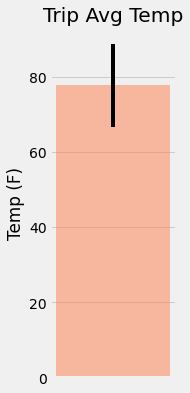

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(2,6))
plt.bar(1,Temp_holiday[0][1],yerr=Temp_holiday_error, color='coral', alpha=0.5)
#Removing xticks
plt.xticks([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.savefig("Images/TripTempSummary.png")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_Measurment_join=session.query(*sel,func.sum(Measurement.prcp)).\
                       group_by(Measurement.station).\
                       order_by(Measurement.station).\
                       filter(Measurement.date>=start_date).\
                       filter(Measurement.date<=end_date).\
                       filter(Measurement.station==Station.station).all()
                        
rainfall_df = pd.DataFrame(station_Measurment_join, columns=['Station','Name', 'Latitude', 'Longtitude', 'Elevation', 'Total Precipitation'])
rainfall_df

,Station,Name,Latitude,Longtitude,Elevation,Total Precipitation
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.59
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.03
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.65
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.18
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.02
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.57
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.30


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

#create a function called daily_normals
def daily_normals(day_date):
    temps = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                          filter(func.strftime("%m-%d", Measurement.date) == day_date).all()
    return temps

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals_list = []
for trip_date in trip_mmdd:
    #unpack daily_normals
    normals_list.append(*daily_normals(trip_date))

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

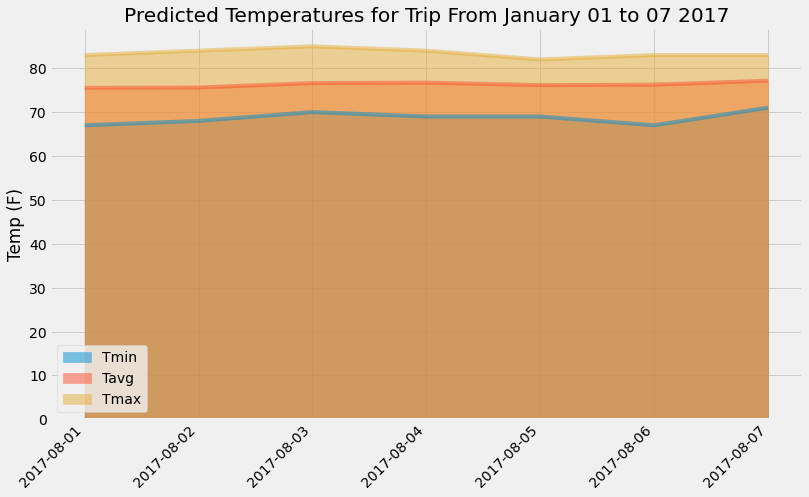

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
#colors = ['mediumslateblue', 'hotpink', 'palegreen']
normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, 
    title='Predicted Temperatures for Trip From January 01 to 07 2017', rot=45)

plt.xlabel('')
plt.ylabel('Temp (F)')
plt.savefig('Images/Predict temperature Jan 2018')
plt.show()

## Close Session

In [17]:
session.close()